In [227]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import typing as tp
import scipy.ndimage
import astropy.units as u
import astropy.constants as const
import astropy.visualization
astropy.visualization.quantity_support()

def rotate(array, angle) -> tp.Tuple[np.ndarray]:
    rot_array = scipy.ndimage.rotate(array, angle, reshape=False)
    return rot_array

## Calculate results of Petschek reconnection

In [252]:
# Constants
mu_0 = const.mu0                # Magnetic constant
m_p = const.m_p                 # Proton mass
m_si = 4.6636*10**(-26)*u.kg    # Atomic mass silicon
k_B = const.k_B                 # Boltzmann constant


# Parameters
zeta = 30*u.deg         # Angle of initial field lines
gamma = 5/3             # Ratio of specific heats

# Internal properties
# B_i = 1
# rho_i = 1
# p_i = 1

# External properties
# Using TR values
beta_e = 10**(-2)
n_e = 10**15*u.m**(-3)    # Proton number density
T_e = 10**5*u.K
rho_e = m_p * n_e
TA_e = T_e/beta_e
v_ae = (np.sqrt(2 * TA_e * k_B/m_p)).to(u.km/u.s)
B_e = (v_ae * np.sqrt(mu_0 * rho_e)).to(u.mT)
p_e = (beta_e * ((B_e**2)/(2 * mu_0))).to(u.kg/(u.km * u.s**2))
## Attempt using Dana's values for corona
# B_e = 1.5*u.mT
# n_e = 3e14*u.m**(-3)    # Proton number density
# T_e = 2*u.MK
# rho_e = m_p * n_e
# v_ae = (B_e/np.sqrt(mu_0 * rho_e)).to(u.km/u.s)
# TA_e = ((m_p/k_B) * (v_ae**2)/2).to(u.MK)
# beta_e = T_e/TA_e
# p_e = (beta_e * ((B_e**2)/(2 * mu_0))).to(u.kg/(u.km * u.s**2))

# Section 1
rho_1 = rho_e
p_1 = p_e
v_x1 = 0
v_z1 = 0
T_1 = ((p_1/rho_1) * (m_p/k_B)).to(u.MK)

# Section 2
rho_2 = rho_1
p_2 = p_1
T_2 = ((p_2/rho_2) * (m_p/k_B)).to(u.MK)
v_x2 = -2 * v_ae * np.sin(zeta/2)**2
v_z2 = -v_ae * np.sin(zeta)

# GDS properties
M_2 = np.sqrt(8/(gamma * beta_e)) * np.sin(zeta/2)**2
v_s = np.abs(v_x2) * (np.sqrt(M_2**(-2) + ((gamma + 1)**2)/16) - (3 - gamma)/4)

# Section 3
beta_3 = beta_e * (1 + gamma * M_2**2 * (1 + v_s/np.abs(v_x2)))
rho_3 = rho_2 * (1 + (np.abs(v_x2)/v_s))
T_3 = TA_e * beta_3 * rho_e/rho_3
v_x3 = 0
v_z3 = v_z2

## Spectral Synthesis

In [253]:
# Try to only use 1D tube as volume, look at several times, look at several angles

# Half tube length
L = 1*u.Mm

# Amount of time for IS bend to reach feet of flux tube
t_max = (L/v_ae).to(u.s)

# Time array
t_array = np.reshape(np.linspace(0, t_max.value, num=100), (-1, 1, 1))*u.s

# Velocity of bend in x direction
v_xae = v_ae * np.cos(zeta)

# Length of section 3 in x direction as a function of time
d_x3_t = 2 * v_s * t_array

# Length of a single section 2 as a function of time
d_x2_t = (v_xae * t_array) - d_x3_t/2

# Length of a single section 1 as a function of time
d_x1_t = (L - (t_array * v_ae)).to(u.km)

In [230]:
# # Create masks for sections 2 and 3 separated by shocks.
# t = 1*u.s   # Time that has passed (arbitrary)
# v_xae = v_ae * np.cos(zeta)
# v_zae = -v_ae * np.sin(zeta)
# phi = (np.arctan(v_s/np.abs(v_zae))).to(u.deg)
# 
# nx = int(np.floor(np.abs(v_xae.value)))
# nz = int(np.floor(np.abs(v_zae.value)))
# x_lim_lo = -t * v_xae
# x_lim_hi = t * v_xae
# z_lim_lo = t * v_zae
# z_lim_hi = -t * v_zae
# x = np.linspace(x_lim_lo, x_lim_hi, num=nx)
# z = np.linspace(z_lim_lo, z_lim_hi, num=nz)
# xv, zv = np.meshgrid(x, z)
# dx = (x[-1] - x[0])/nx
# dz = (z[-1] - z[0])/nz
# 
# # Lines representing shocks
# z1 = xv * np.tan(zeta)
# z2 = xv * np.tan(90*u.deg - phi)
# 
# # Masks
# mask_2 = np.zeros((nz, nx))
# ind = np.logical_and(np.abs(z1) < np.abs(zv), np.abs(zv) < np.abs(z2))
# mask_2[ind] = 1
# mask_3 = np.zeros((nz, nx))
# mask_3[np.abs(zv) > np.abs(z2)] = 1
# 
# # Pad masks so they may be rotated and not have necessary information rotate out of frame
# x_pad = int(np.ceil((np.sqrt(len(x)**2 + len(z)**2) - len(x))/2))
# z_pad = int(np.ceil((np.sqrt(len(x)**2 + len(z)**2) - len(z))/2))
# mask_2p = np.pad(mask_2, [(z_pad, z_pad), (x_pad, x_pad)], mode='constant')
# mask_3p = np.pad(mask_3, [(z_pad, z_pad), (x_pad, x_pad)], mode='constant')
# 
# # New x and z ranges
# x_new = dx * (-mask_2p.shape[1]//2 + np.arange(mask_2p.shape[1]))
# z_new = dz * (-mask_2p.shape[0]//2 + np.arange(mask_2p.shape[0]))
# 
# # Plot masks
# plt.imshow(mask_2p, extent=[x_new.min().value, x_new.max().value, z_new.min().value, z_new.max().value])
# plt.figure()
# plt.imshow(mask_3p, extent=[x_new.min().value, x_new.max().value, z_new.min().value, z_new.max().value])

In [254]:
# Rotation parameters

# num_ang = 33    # Number of unique angles to sample
num_ang = 364    # Number of unique angles to sample
# ang = np.linspace(0, 360, num_ang, endpoint=False)
ang = np.linspace(0, 90, num_ang)*u.deg

In [232]:
# Only use if interested in intensity as a function of position along x...

# field_2_array = np.empty((0, *mask_2p.shape))
# field_3_array = np.empty((0, *mask_3p.shape))
# 
# for angle in ang:
#     field_2 = rotate(mask_2p, angle)
#     field_3 = rotate(mask_3p, angle)
#     field_2_array = np.append(field_2_array, [field_2], axis=0)
#     field_3_array = np.append(field_3_array, [field_3], axis=0)
# 
# # Plots of rotated density fields
# plt.imshow(field_2_array[5, :, :], extent=[x_new.min().value, x_new.max().value, z_new.min().value, z_new.max().value])
# plt.figure()
# plt.imshow(field_3_array[5, :, :], extent=[x_new.min().value, x_new.max().value, z_new.min().value, z_new.max().value])
# 
# # Integrate down columns to get density along x (not really needed...)
# 
# rhox_2 = np.sum(field_2_array[5, :, :], axis=0)
# rhox_3 = np.sum(field_3_array[5, :, :], axis=0)
# plt.plot(x_new, rhox_2)
# plt.figure()
# plt.plot(x_new, rhox_3)

In [255]:
# # Total area in each section:
# Vol_2 = np.sum(mask_2p) * dx * dz * 1*u.km
# Vol_3 = np.sum(mask_3p) * dx * dz * 1*u.km

# One dimentional "volume" in each section:
Vol_1 = d_x1_t
Vol_2 = d_x2_t
Vol_3 = d_x3_t

# Intensity from each section
I_1 = (rho_1**2 * Vol_1)
I_2 = (rho_2**2 * Vol_2)
I_3 = (rho_3**2 * Vol_3)

# Amplitudes
amp_1 = (I_1).to(u.kg**2/u.km**5)
amp_2 = (I_2).to(u.kg**2/u.km**5)
amp_3 = (I_3).to(u.kg**2/u.km**5)

# Velocities along line of sight after rotation (LOS = z dir)
# Section 2 (right)
v_z2R_los = v_z2 * np.cos(ang)
v_x2R_los = v_x2 * np.sin(ang)
peak_2R = v_z2R_los + v_x2R_los

# Section 2 (left)
v_z2L_los = v_z2 * np.cos(ang)
v_x2L_los = -v_x2 * np.sin(ang)
peak_2L = v_z2L_los + v_x2L_los

# Section 3
peak_3 = v_z3 * np.cos(ang)

In [263]:
v_range = np.linspace(v_z3 - (100*u.km/u.s), -v_z3 + (100*u.km/u.s), num=400)
v_range = np.reshape(v_range, (1, -1, 1))

# Section 1 spectral lines

# Thermal speed of silicon in section 1
v_th1 = (np.sqrt(k_B * T_1/m_si)).to(u.km/u.s) 

# Model thermally broadened spectral lines from section 1
line_lo1R = amp_1 * np.exp(-(v_range**2)/(2 * v_th1**2))
line_hi1R = amp_1 * np.exp(-(v_range**2)/(2 * v_th1**2))
lines_1R = line_lo1R + line_hi1R

line_lo1L = amp_1 * np.exp(-(v_range**2)/(2 * v_th1**2))
line_hi1L = amp_1 * np.exp(-(v_range**2)/(2 * v_th1**2))
lines_1L = line_lo1L + line_hi1L


# Section 2 spectral lines

# Thermal speed of silicon in section 2
v_th2 = (np.sqrt(k_B * T_2/m_si)).to(u.km/u.s)  

# Model thermally broadened spectral lines from section 2
line_lo2R = amp_2 * np.exp(-((v_range - peak_2R)**2)/(2 * v_th2**2))
line_hi2R = amp_2 * np.exp(-((v_range + peak_2R)**2)/(2 * v_th2**2))
lines_2R = line_lo2R + line_hi2R

line_lo2L = amp_2 * np.exp(-((v_range - peak_2L)**2)/(2 * v_th2**2))
line_hi2L = amp_2 * np.exp(-((v_range + peak_2L)**2)/(2 * v_th2**2))
lines_2L = line_lo2L + line_hi2L


# Section 3 spectral lines

# Thermal speed of silicon in section 3
v_th3 = (np.sqrt(k_B * T_3/m_si)).to(u.km/u.s)  

# Model thermally broadened spectral lines from section 2
line_lo3 = amp_3 * np.exp(-((v_range - peak_3)**2)/(2 * v_th3**2))
line_hi3 = amp_3 * np.exp(-((v_range + peak_3)**2)/(2 * v_th3**2))
lines_3 = line_lo3 + line_hi3


# Total spectrum
spectrum = lines_1R + lines_1L + lines_2R + lines_2L + lines_3


In [235]:
# # Plot spectrum at each angle
# 
# angle = list(range(len(ang)))
# for a in angle:
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     pos = ax.imshow(spectrum[:,:,a].value/spectrum.value.max(), vmax= 1, extent=[v_range.min().value, v_range.max().value, t_array.max().value, t_array.min().value])
#     ax.set_aspect(750)
#     ax.set_title('Angle ' + str(ang[a]))
#     ax.set_xlabel('Doppler velocity [km/s]')
#     ax.set_ylabel('Time [s]')
#     fig.colorbar(pos)

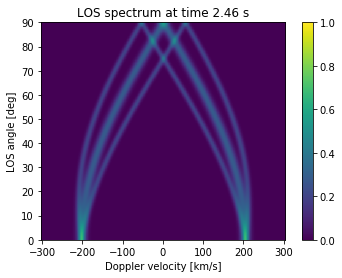

In [268]:
# Plot spectrum as a function of angle and Doppler velocity
t_index = 99
fig = plt.figure()
ax = fig.add_subplot(111)
pos = ax.imshow(spectrum[t_index,:,:].T.value/spectrum.value.max(), vmax= 1, origin= 'lower', extent=[v_range.min().value, v_range.max().value, ang.min().value, ang.max().value])
ax.set_aspect(6)
ax.set_title('LOS spectrum at time ' + str(round(t_array[t_index,0,0].value, ndigits=2)) + ' s')
ax.set_xlabel('Doppler velocity [km/s]')
ax.set_ylabel('LOS angle [deg]')
fig.colorbar(pos)
